<a href="https://colab.research.google.com/github/wandersonxs/Financas-Machine-Learning-Course/blob/main/Copy_of_1_NN_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock price prediction using LSTM neural network and Tensorflow
What do we need here:
1. Load data
2. Scale data for machine learning model
3. Setup neural network
4. Compile model
5. Teach neural netowk and fit this
6. Use the model for prediction
7. Draw the results chart

In [ ]:
# Requirements
!pip install yahoo_fin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 4.8 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=1cbccfe254713fce557523f67d5461069bdefd342ab75a9aa36e386b9096f3ec
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


In [ ]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

In [ ]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'GOOGL'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [ ]:
# LOAD DATA
# from yahoo_fin
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK,
    start_date=date_3_years_back,
    end_date=date_now,
    interval='1d')

In [ ]:
init_df

,open,high,low,close,adjclose,volume,ticker
2019-09-09,60.354000,61.027500,59.658501,60.263500,60.263500,31854000,GOOGL
2019-09-10,59.804501,60.500000,59.800499,60.285000,60.285000,27922000,GOOGL
2019-09-11,60.194500,61.123501,60.113998,61.000000,61.000000,23522000,GOOGL
2019-09-12,61.173500,62.120998,61.127998,61.748501,61.748501,31644000,GOOGL
2019-09-13,61.605499,62.052502,61.354000,62.001499,62.001499,23676000,GOOGL
...,...,...,...,...,...,...,...
2022-09-12,110.989998,111.620003,109.930000,110.860001,110.860001,22966800,GOOGL
2022-09-13,107.800003,108.300003,104.089996,104.320000,104.320000,38172900,GOOGL
2022-09-14,104.570000,105.279999,103.660004,105.000000,105.000000,26395100,GOOGL
2022-09-15,104.029999,105.269997,102.349998,102.910004,102.910004,34188300,GOOGL


In [ ]:
# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

In [ ]:
init_df

,close,date
2019-09-09,60.263500,2019-09-09
2019-09-10,60.285000,2019-09-10
2019-09-11,61.000000,2019-09-11
2019-09-12,61.748501,2019-09-12
2019-09-13,62.001499,2019-09-13
...,...,...
2022-09-12,110.860001,2022-09-12
2022-09-13,104.320000,2022-09-13
2022-09-14,105.000000,2022-09-14
2022-09-15,102.910004,2022-09-15


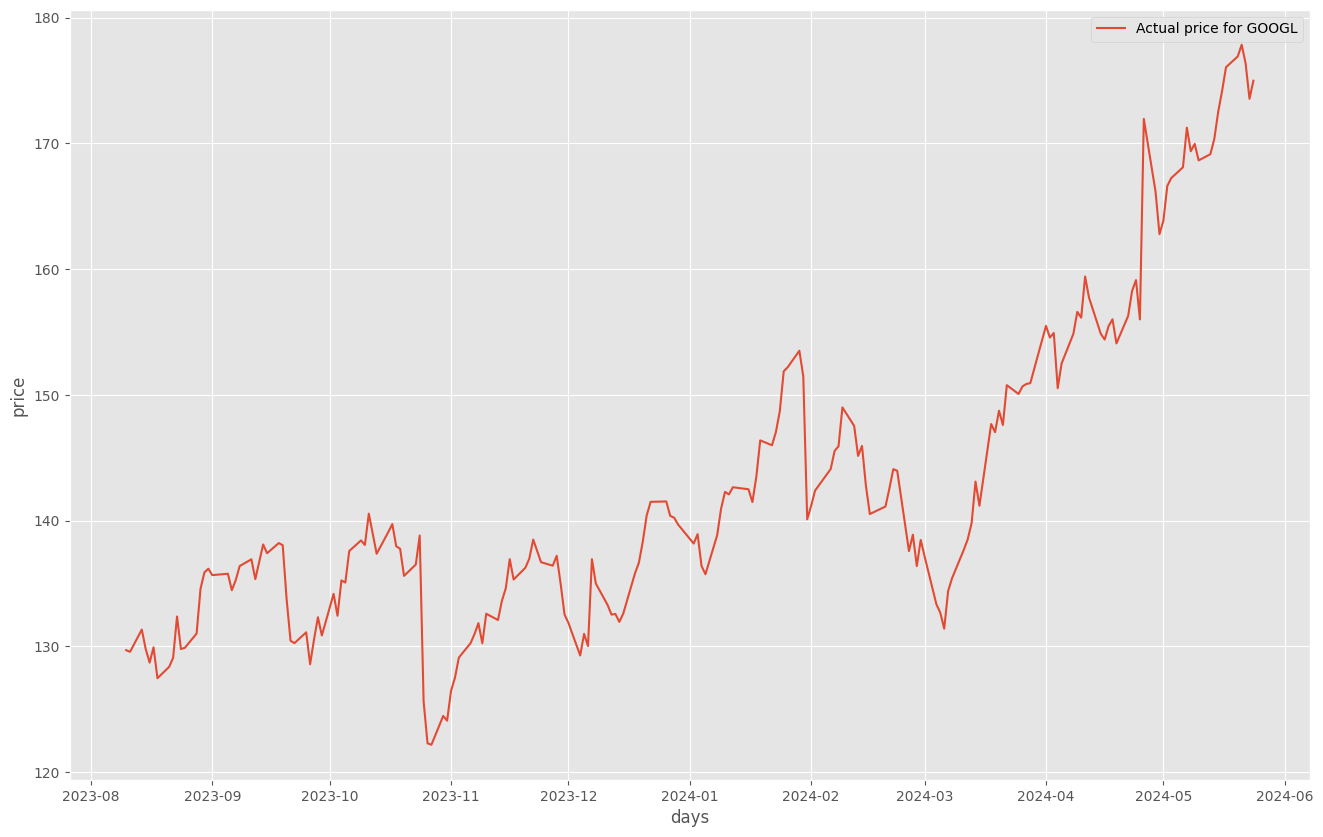

In [ ]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [ ]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['scaled_close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [ ]:
init_df

,close,date,scaled_close
2021-05-17,114.445999,2021-05-17,0.328490
2021-05-18,113.123497,2021-05-18,0.314483
2021-05-19,113.574997,2021-05-19,0.319265
2021-05-20,115.347504,2021-05-20,0.338038
2021-05-21,114.706497,2021-05-21,0.331249
...,...,...,...
2024-05-20,176.919998,2024-05-20,0.990150
2024-05-21,177.850006,2024-05-21,1.000000
2024-05-22,176.380005,2024-05-22,0.984431
2024-05-23,173.550003,2024-05-23,0.954459


In [ ]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [ ]:
PrepareData(3) # 3 days

(                 close       date  scaled_close    future
 2021-05-17  114.445999 2021-05-17      0.328490  0.338038
 2021-05-18  113.123497 2021-05-18      0.314483  0.331249
 2021-05-19  113.574997 2021-05-19      0.319265  0.366681
 2021-05-20  115.347504 2021-05-20      0.338038  0.367650
 2021-05-21  114.706497 2021-05-21      0.331249  0.376885
 ...                ...        ...           ...       ...
 2024-05-15  172.509995 2024-05-15      0.943444  0.990150
 2024-05-16  174.179993 2024-05-16      0.961131  1.000000
 2024-05-17  176.059998 2024-05-17      0.981042  0.984431
 2024-05-20  176.919998 2024-05-20      0.990150  0.954459
 2024-05-21  177.850006 2024-05-21      1.000000  0.969710
 
 [759 rows x 4 columns],
 array([[0.9077525 ],
        [0.92046165],
        [0.9434441 ],
        [0.961131  ],
        [0.9810421 ],
        [0.99015033],
        [1.        ],
        [0.98443127],
        [0.9544588 ],
        [0.9697098 ]], dtype=float32),
 array([[[0.3284896942982117

In [ ]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [ ]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
95/95 [==============================] - 8s 15ms/step - loss: 0.0141
Epoch 2/80
95/95 [==============================] - 1s 15ms/step - loss: 0.0040
Epoch 3/80
95/95 [==============================] - 1s 15ms/step - loss: 0.0036
Epoch 4/80
95/95 [==============================] - 1s 14ms/step - loss: 0.0035
Epoch 5/80
95/95 [==============================] - 1s 14ms/step - loss: 0.0034
Epoch 6/80
95/95 [==============================] - 2s 16ms/step - loss: 0.0029
Epoch 7/80
95/95 [==============================] - 2s 21ms/step - loss: 0.0027
Epoch 8/80
95/95 [==============================] - 2s 21ms/step - loss: 0.0023
Epoch 9/80
95/95 [==============================] - 1s 15ms/step - loss: 0.0023
Epoch 10/80
95/95 [==============================] - 1s 14ms/step - loss: 0.0026
Epoch 11/80
95/95 [==============================] - 1s 14ms/step - loss: 0.0024
Epoch 12/80
95/95 [==============================] - 1s 14ms/step - loss: 0.0023
Epoch 13/80
95/95 [==================

In [ ]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'

  print(message)

GOOGL prediction for upcoming 3 days (170.65$, 173.14$, 176.44$)


In [ ]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

24/24 [==============================] - 0s 6ms/step


In [ ]:
copy_df

,close,date,scaled_close,predicted_close
2021-05-17,114.445999,2021-05-17,0.328490,117.842499
2021-05-18,113.123497,2021-05-18,0.314483,119.058998
2021-05-19,113.574997,2021-05-19,0.319265,118.529503
2021-05-20,115.347504,2021-05-20,0.338038,117.378998
2021-05-21,114.706497,2021-05-21,0.331249,119.678497
...,...,...,...,...
2024-05-20,176.919998,2024-05-20,0.990150,177.153046
2024-05-21,177.850006,2024-05-21,1.000000,178.399963
2024-05-22,176.380005,2024-05-22,0.984431,176.380005
2024-05-23,173.550003,2024-05-23,0.954459,173.550003


In [ ]:
# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

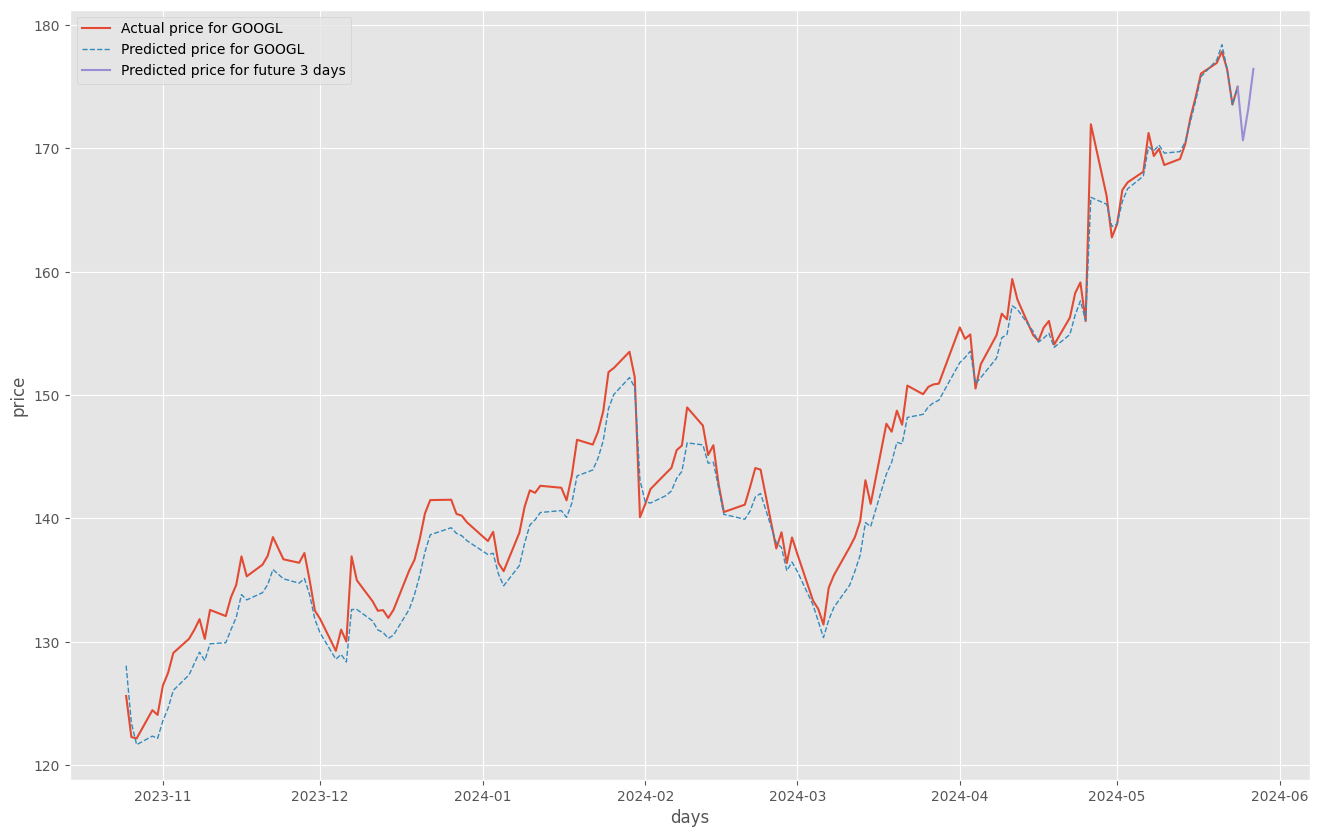

In [ ]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()